---------------------------------
1. Imports e Configurações
---------------------------------

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


---------------------------------
2. Caminhos dos Arquivos + Carregar arquivos
---------------------------------

In [27]:
RAW = r"C:\Users\levie\asasas\projeto_ml\data\raw\delivery_time.csv"
CLEAN = r"C:\Users\levie\asasas\projeto_ml\data\processed\delivery_clean.csv"
SCALED = r"C:\Users\levie\asasas\projeto_ml\data\processed\delivery_processed.csv"

# carregar raw (erro se faltar — arquivo raw é obrigatório)
if not os.path.exists(RAW):
    raise FileNotFoundError(f"Arquivo RAW não encontrado: {RAW}")
df_raw = pd.read_csv(RAW)

# carregar clean/processed se existirem; caso contrário criar cópias a partir do raw
if os.path.exists(CLEAN):
    df_clean = pd.read_csv(CLEAN)
else:
    print("WARNING: arquivo CLEAN não encontrado — usando cópia de raw como df_clean (execute células de preprocessamento).")
    df_clean = df_raw.copy()

if os.path.exists(SCALED):
    df_scaled = pd.read_csv(SCALED)
else:
    print("WARNING: arquivo SCALED não encontrado — usando df_clean como df_scaled (execute pré-processamento).")
    df_scaled = df_clean.copy()

print("Shapes — raw:", df_raw.shape, "clean:", df_clean.shape, "scaled:", df_scaled.shape)
display(df_raw.head())
display(df_clean.head())
display(df_scaled.head())
# ...existing code...



Shapes — raw: (2510, 17) clean: (2510, 17) scaled: (2510, 87)


,delivery_id,distance_km,package_weight_kg,delivery_type,vehicle_type,traffic_condition,weather,time_of_day,day_of_week,driver_experience_years,num_stops,is_priority,package_fragile,delivery_zone,customer_rating,fuel_cost,delivery_time_hours
0,DEL00331,17.62,12.45,Express,Carro,Médio,Ensolarado,Tarde,domingo,5.0,8,No,No,Urbana,3.75,5.41,22.59
1,DEL02382,11.43,3.31,Economy,Carro,Médio,Ensolarado,Manhã,Seg-Qui,8.0,2,No,Yes,Urbana,3.68,5.73,19.18
2,DEL00825,25.87,2.79,Express,Carro,Baixo,Ensolarado,Manhã,Seg-Qui,NaN,1,No,Yes,Urbana,2.98,6.13,3.92
3,DEL00336,14.21,6.99,Standard,Caminhão,Médio,Chuva Forte,Tarde,Domingo,7.0,1,Yes,Yes,Suburbana,2.10,5.34,24.66
4,DEL00551,14.31,NaN,Standard,Van,Alto,Nublado,Manhã,Sábado,1.0,1,No,Yes,Urbana,3.31,6.57,23.05


,delivery_id,distance_km,package_weight_kg,delivery_type,vehicle_type,traffic_condition,weather,time_of_day,day_of_week,driver_experience_years,num_stops,is_priority,package_fragile,delivery_zone,customer_rating,fuel_cost,delivery_time_hours
0,DEL00331,17.62,12.18375,Express,Carro,Médio,Ensolarado,Tarde,domingo,5.0,6.0,No,No,Urbana,3.75,5.41,22.59
1,DEL02382,11.43,3.31000,Economy,Carro,Médio,Ensolarado,Manhã,Seg-Qui,8.0,2.0,No,Yes,Urbana,3.68,5.73,19.18
2,DEL00825,25.87,2.79000,Express,Carro,Baixo,Ensolarado,Manhã,Seg-Qui,4.0,1.0,No,Yes,Urbana,2.98,6.13,3.92
3,DEL00336,14.21,6.99000,Standard,Caminhão,Médio,Chuva Forte,Tarde,Domingo,7.0,1.0,Yes,Yes,Suburbana,2.10,5.34,24.66
4,DEL00551,14.31,4.97000,Standard,Van,Alto,Nublado,Manhã,Sábado,1.0,1.0,No,Yes,Urbana,3.31,6.57,23.05


,distance_km,package_weight_kg,driver_experience_years,num_stops,customer_rating,fuel_cost,delivery_time_hours,delivery_type_ Express,delivery_type_ Standard,delivery_type_Economy,...,package_fragile_no,package_fragile_yes,delivery_zone_ Suburbana,delivery_zone_ Urbana,delivery_zone_Rural,delivery_zone_Suburbana,delivery_zone_Urbana,delivery_zone_suburbana,delivery_zone_urbana,delivery_id
0,0.209860,2.644957,0.091559,3.108428,1.700263,-0.126139,0.384929,False,False,False,...,False,False,False,False,False,False,True,False,False,DEL00331
1,-0.470552,-0.680072,1.179863,-0.081985,1.554082,0.288737,0.005903,False,False,True,...,False,False,False,False,False,False,True,False,False,DEL02382
2,1.116710,-0.874918,-0.271209,-0.879588,0.092268,0.807332,-1.690263,False,False,False,...,False,False,False,False,False,False,True,False,False,DEL00825
3,-0.164971,0.698838,0.817095,-0.879588,-1.745441,-0.216893,0.615012,False,False,False,...,False,False,False,False,False,True,False,False,False,DEL00336
4,-0.153979,-0.058064,-1.359513,-0.879588,0.781409,1.377787,0.436058,False,False,False,...,False,False,False,False,False,False,True,False,False,DEL00551


---------------------------------
4. Verificar Valores Negativos
---------------------------------

In [28]:
cols_to_check = [
    "distance_km",
    "package_weight_kg",
    "driver_experience_years",
    "num_stops",
    "customer_rating",
    "fuel_cost",
    "delivery_time_hours"
]

for col in cols_to_check:
    neg_count = (df_clean[col] < 0).sum()
    if neg_count > 0:
        print(f"⚠️ {col} possui {neg_count} valores negativos!")
    else:
        print(f"✔️ {col} está sem valores negativos.")


✔️ distance_km está sem valores negativos.
✔️ package_weight_kg está sem valores negativos.
✔️ driver_experience_years está sem valores negativos.
✔️ num_stops está sem valores negativos.
✔️ customer_rating está sem valores negativos.
✔️ fuel_cost está sem valores negativos.
✔️ delivery_time_hours está sem valores negativos.


---------------------------------
5. Gráfico de Comparação (Raw vs Clean vs Scaled)
---------------------------------

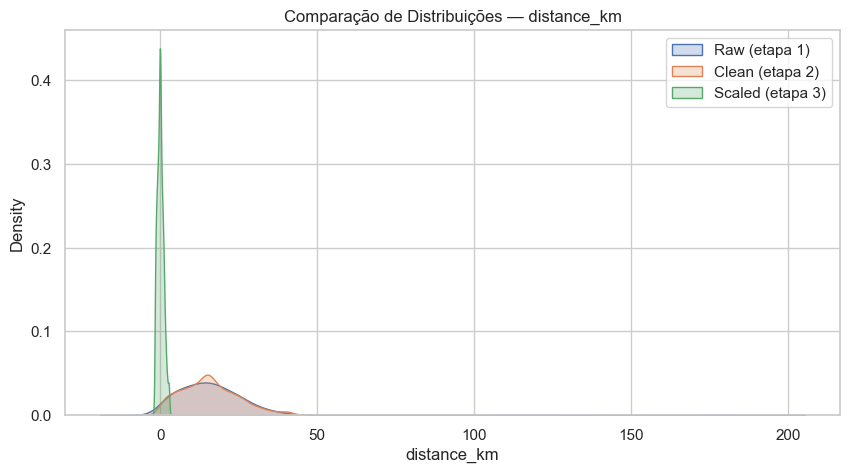

In [38]:
col = "distance_km"  

plt.figure(figsize=(10,5))
sns.kdeplot(df_raw[col], label="Raw (etapa 1)", fill=True)
sns.kdeplot(df_clean[col], label="Clean (etapa 2)", fill=True)
sns.kdeplot(df_scaled[col], label="Scaled (etapa 3)", fill=True)

plt.title(f"Comparação de Distribuições — {col}")
plt.legend()
plt.show()


---------------------------------
6. Resolver Valores Negativos
---------------------------------

In [30]:
for col in ["distance_km", "package_weight_kg"]:
    df_clean[col] = df_clean[col].abs()

df_clean.to_csv(CLEAN, index=False)
print("Valores negativos corrigidos e arquivo salvo.")


Valores negativos corrigidos e arquivo salvo.


---------------------------------
7. Revalidar Após a Correção
---------------------------------

In [31]:
import numpy as np

# usa cols_fix se definida; caso contrário tenta cols_to_check; senão usa todas as numéricas em df_clean
cols_fix = globals().get('cols_fix') or globals().get('cols_to_check')
if cols_fix is None:
    cols_fix = [c for c in df_clean.select_dtypes(include=[np.number]).columns.tolist()]

print("Revalidando colunas:", cols_fix)
for col in cols_fix:
    if col not in df_clean.columns:
        print(f"⚠️ Coluna '{col}' não encontrada em df_clean — pulando.")
        continue
    neg_remaining = (df_clean[col] < 0).sum()
    print(f"{col}: negativos restantes = {neg_remaining}")

Revalidando colunas: ['distance_km', 'package_weight_kg', 'driver_experience_years', 'num_stops', 'customer_rating', 'fuel_cost', 'delivery_time_hours']
distance_km: negativos restantes = 0
package_weight_kg: negativos restantes = 0
driver_experience_years: negativos restantes = 0
num_stops: negativos restantes = 0
customer_rating: negativos restantes = 0
fuel_cost: negativos restantes = 0
delivery_time_hours: negativos restantes = 0


---------------------------------
8. Gráfico de Comparação Após Correção
---------------------------------

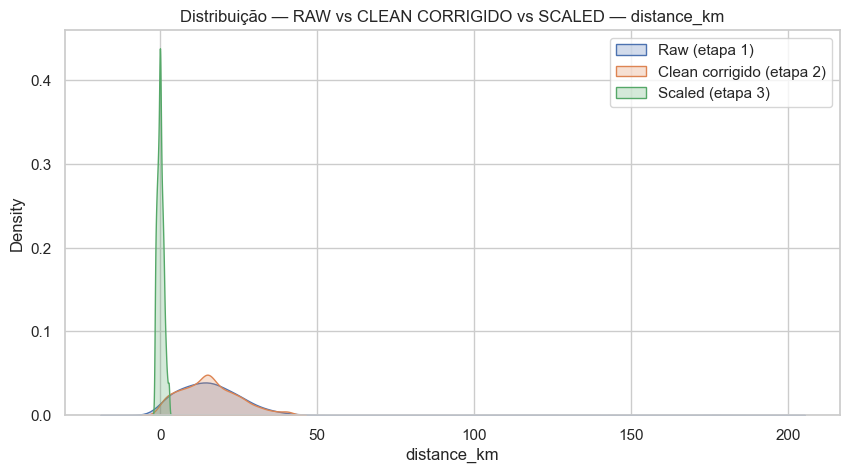

In [32]:
col = "distance_km" 

plt.figure(figsize=(10,5))
sns.kdeplot(df_raw[col], label="Raw (etapa 1)", fill=True)
sns.kdeplot(df_clean[col], label="Clean corrigido (etapa 2)", fill=True)
sns.kdeplot(df_scaled[col], label="Scaled (etapa 3)", fill=True)

plt.title(f"Distribuição — RAW vs CLEAN CORRIGIDO vs SCALED — {col}")
plt.legend()
plt.show()


---------------------------------
9. Mostrar Estatísticas das Três Versões
---------------------------------

In [33]:
# CÉLULA 09 — Estatísticas principais
pd.DataFrame({
    "Raw": df_raw.describe().iloc[1],
    "Clean Corrigido": df_clean.describe().iloc[1],
    "Scaled": df_scaled.describe().iloc[1]
})


,Raw,Clean Corrigido,Scaled
distance_km,16.552603,15.710813,9.624882e-17
package_weight_kg,5.578324,5.124959,1.740971e-16
driver_experience_years,4.870917,4.747610,5.803237e-17
num_stops,2.216733,2.102789,1.132339e-17
customer_rating,2.937696,2.935817,-1.896668e-16
fuel_cost,5.508837,5.507293,2.788385e-16
delivery_time_hours,19.142442,19.126888,-1.174802e-16


---------------------------------
10. Teste Scaler
---------------------------------


📌 INFORMAÇÕES INICIAIS
Coluna analisada: distance_km
Colunas escaladas: ['distance_km', 'package_weight_kg', 'driver_experience_years', 'num_stops', 'customer_rating', 'fuel_cost', 'delivery_time_hours']
Existe no processed: True

📊 TESTE 1 — Estatísticas RAW vs CLEAN vs PROCESSED
RAW   → min / median / mean / max: -9.62 15.02 16.552603254067588 195.8
CLEAN → min / median / mean / max: 0.03 15.02 15.710812749003983 40.62375
PROC  → min / median / mean / max: -1.7236544160724157 -0.0759349954979517 9.624881679618887e-17 2.7384610094742583

📈 TESTE 2 — Gráficos de Distribuição


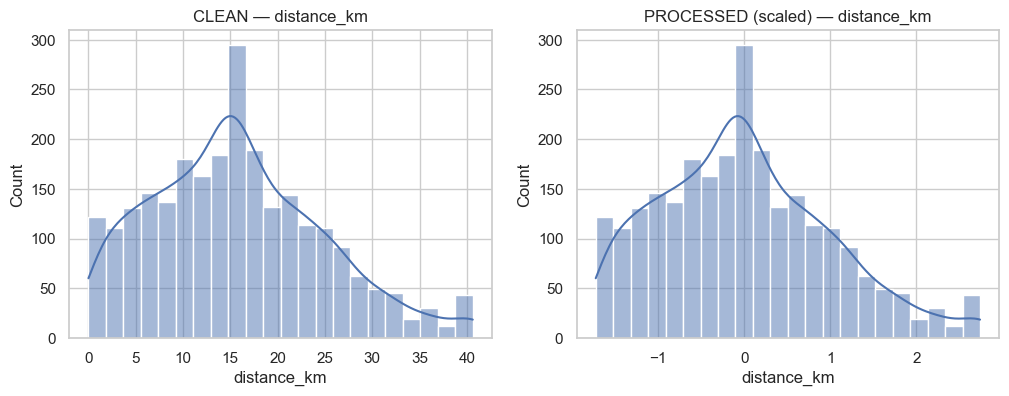


🧩 TESTE 3 — Verificando se a coluna virou dummies
Nenhuma dummy encontrada — é uma coluna numérica normal.

🔄 TESTE 4 — Inversão do StandardScaler
Valores invertidos (min/median/max): 0.02999999999999936 15.02 40.62375

🧠 DIAGNÓSTICO FINAL
✔ A coluna foi escalada corretamente.
Se existe pico, provavelmente é:
- distribuição muito concentrada (normal);
- valores discretos;
- ou outliers que foram limitados.


In [34]:
# ===========================================
# 🔎 CÉLULA ÚNICA — DIAGNÓSTICO COMPLETO DO SCALER
# ===========================================

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# --- paths (ajuste se necessário)
RAW = r"C:\Users\levie\asasas\projeto_ml\data\raw\delivery_time.csv"
OUT_CLEAN = r"C:\Users\levie\asasas\projeto_ml\data\processed\delivery_clean.csv"
OUT_PROCESSED = r"C:\Users\levie\asasas\projeto_ml\data\processed\delivery_processed.csv"
SCALER_PATH = r"C:\Users\levie\asasas\projeto_ml\models\scaler.pkl"
META_PATH = r"C:\Users\levie\asasas\projeto_ml\models\preprocess_meta.pkl"

# --- coluna que você quer diagnosticar
col = "distance_km"     # 👈 TROQUE AQUI

# --- carregar dados e objetos
df_raw = pd.read_csv(RAW)
df_clean = pd.read_csv(OUT_CLEAN)
df_processed = pd.read_csv(OUT_PROCESSED)
scaler = joblib.load(SCALER_PATH)
meta = joblib.load(META_PATH)

numeric_to_scale = meta.get("numeric_to_scale", [])

print("\n==============================")
print("📌 INFORMAÇÕES INICIAIS")
print("==============================")
print("Coluna analisada:", col)
print("Colunas escaladas:", numeric_to_scale)
print("Existe no processed:", col in df_processed.columns)

if col not in df_raw.columns:
    print(f"\n❌ ERRO: coluna {col} não existe no RAW. Verifique o nome.")
    raise SystemExit()

if col not in df_clean.columns:
    print(f"\n❌ ERRO: coluna {col} não existe no CLEAN. Verifique o nome.")
    raise SystemExit()

# =======================================================
# TESTE 1 — Estatísticas antes/depois
# =======================================================
print("\n==============================")
print("📊 TESTE 1 — Estatísticas RAW vs CLEAN vs PROCESSED")
print("==============================")

orig = df_clean[col]
proc = df_processed[col] if col in df_processed.columns else None

print("RAW   → min / median / mean / max:", 
      df_raw[col].min(), df_raw[col].median(), df_raw[col].mean(), df_raw[col].max())
print("CLEAN → min / median / mean / max:", 
      orig.min(), orig.median(), orig.mean(), orig.max())

if proc is not None:
    print("PROC  → min / median / mean / max:",
          proc.min(), proc.median(), proc.mean(), proc.max())
else:
    print("PROC  → coluna não está no df_processed (possível one-hot).")

# =======================================================
# TESTE 2 — Plotar distribuições
# =======================================================
print("\n==============================")
print("📈 TESTE 2 — Gráficos de Distribuição")
print("==============================")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(orig.dropna(), kde=True)
plt.title(f"CLEAN — {col}")

plt.subplot(1,2,2)
if proc is not None:
    sns.histplot(proc.dropna(), kde=True)
    plt.title(f"PROCESSED (scaled) — {col}")
else:
    plt.text(0.3, 0.5, "Coluna não está no processed", fontsize=14)
plt.show()

# =======================================================
# TESTE 3 — Verificar se virou one-hot (dummies)
# =======================================================
print("\n==============================")
print("🧩 TESTE 3 — Verificando se a coluna virou dummies")
print("==============================")

related = [c for c in df_processed.columns if c.startswith(col + "_")]
if len(related) > 0:
    print("A coluna original virou as seguintes dummies:")
    print(related)
else:
    print("Nenhuma dummy encontrada — é uma coluna numérica normal.")

# =======================================================
# TESTE 4 — Inversão do scaling
# =======================================================
print("\n==============================")
print("🔄 TESTE 4 — Inversão do StandardScaler")
print("==============================")

if col in numeric_to_scale:
    idx = numeric_to_scale.index(col)
    scaled_vals = df_processed[col].to_numpy()
    inv = scaled_vals * scaler.scale_[idx] + scaler.mean_[idx]

    print("Valores invertidos (min/median/max):",
          np.nanmin(inv), np.nanmedian(inv), np.nanmax(inv))
else:
    print("A coluna NÃO está em numeric_to_scale → não passou pelo scaler.")

# =======================================================
# DIAGNÓSTICO FINAL
# =======================================================
print("\n==============================")
print("🧠 DIAGNÓSTICO FINAL")
print("==============================")

dummy_flag = len(related) > 0
scaled_flag = col in numeric_to_scale

if dummy_flag:
    print("✔ A coluna virou várias colunas one-hot ⚠️")
    print("Picos altos são NORMAIS em distribuições one-hot + scaler.")
elif not scaled_flag and col in df_processed:
    print("⚠ A coluna existe no processed mas NÃO está na lista numeric_to_scale.")
    print("Isso pode gerar comportamento estranho no gráfico.")
elif scaled_flag:
    print("✔ A coluna foi escalada corretamente.")
    print("Se existe pico, provavelmente é:")
    print("- distribuição muito concentrada (normal);")
    print("- valores discretos;")
    print("- ou outliers que foram limitados.")
else:
    print("❌ Algo está inconsistente: coluna não aparece no processed.")
